<a href="https://colab.research.google.com/github/chaitu-p04/VisionCare-Eye-Disease-Classification/blob/main/Eye_diseases_classification_by_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VISIONCARE: EYE DISEASE CLASSIFICATION

*The following dataset is about 4 types of eye diseases and we are trying to build a model that can recognize the type of disease in 4 classifications based on the available image data of the eyes.*

Our four categories include: <br>
1. Cataract <br>
2. Diabetic Retinopathy <br>
3. Glaucoma <br>
4. Normal

Data link:<br>
https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split      # dividing the dataset
from sklearn.preprocessing import LabelEncoder            # for converting str labels to number
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sn
import random


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all messages, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint ,Callback # type: ignore
from tensorflow.keras import layers, models ,optimizers # type: ignore
from tensorflow.keras.models import load_model # type: ignore
from tensorflow.keras.layers import GlobalAveragePooling2D # type: ignore
from tensorflow.keras.applications import EfficientNetB0 # type: ignore
import pathlib

import warnings
warnings.filterwarnings("ignore")

In [ ]:
tf.version.VERSION

'2.17.0'

# Exploratory analysis of image data

In [ ]:

def dataset_analysis(path):
    subfolders = os.listdir(path)

    for subfolder in subfolders:
        subfolder_path = os.path.join(path, subfolder)
        if os.path.isdir(subfolder_path):
            files = os.listdir(subfolder_path)
            format_dimensions_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

            for file in files:
                try:
                    file_path = os.path.join(subfolder_path, file)
                    with Image.open(file_path) as img:
                        image_type = img.format.upper()  # Format (e.g., JPEG, PNG)
                        image_dimensions = img.size  # (width, height)
                        image_mode = img.mode  # Mode (e.g., RGB, L)


                        # Calculate bit depth
                        if image_mode == "1":  # 1-bit pixels, black and white, stored with one pixel per byte
                            bit_depth = 1
                        elif image_mode == "L":  # 8-bit pixels, grayscale
                            bit_depth = 8
                        elif image_mode == "P":  # 8-bit pixels, mapped to any other mode using a color palette
                            bit_depth = 8
                        elif image_mode == "RGB":  # 8-bit pixels, true color
                            bit_depth = 24  # 8 bits per channel
                        elif image_mode == "RGBA":  # 8-bit pixels, true color with transparency mask
                            bit_depth = 32  # 8 bits per channel
                        elif image_mode == "CMYK":  # 8-bit pixels, color separation
                            bit_depth = 32  # 8 bits per channel
                        else:
                            bit_depth = "Unknown"

                        format_dimensions_counts[image_type][(image_dimensions, bit_depth)][image_mode] += 1
                except Exception as e:
                    print(f"Exception processing '{file}' in '{subfolder}': {e}")

            print('--------'*10)
            print(f"Subfolder '{subfolder}' contains ({len(files)} files):")
            for format, dimensions_counts in format_dimensions_counts.items():
                print(f"- {sum(sum(counts.values()) for counts in dimensions_counts.values())} images of format {format}:")
                for (dimensions, bit_depth), counts in dimensions_counts.items():
                    for mode, count in counts.items():
                        print(f"  - {count} images with dimensions {dimensions}, bit depth {bit_depth}, mode {mode}")



path = '/content/drive/MyDrive/Colab Notebooks/archive/eye-diseases-classification'
dataset_path = path
dataset_analysis(dataset_path)


--------------------------------------------------------------------------------
Subfolder 'glaucoma' contains (1007 files):
- 906 images of format JPEG:
  - 306 images with dimensions (512, 512), bit depth 24, mode RGB
  - 600 images with dimensions (256, 256), bit depth 24, mode RGB
- 101 images of format PNG:
  - 74 images with dimensions (2592, 1728), bit depth 24, mode RGB
  - 22 images with dimensions (2464, 1632), bit depth 24, mode RGB
  - 5 images with dimensions (1848, 1224), bit depth 24, mode RGB
--------------------------------------------------------------------------------
Subfolder 'normal' contains (1074 files):
- 1074 images of format JPEG:
  - 1074 images with dimensions (512, 512), bit depth 24, mode RGB
--------------------------------------------------------------------------------
Subfolder 'diabetic_retinopathy' contains (1108 files):
- 1108 images of format JPEG:
  - 1108 images with dimensions (512, 512), bit depth 24, mode RGB
--------------------------------

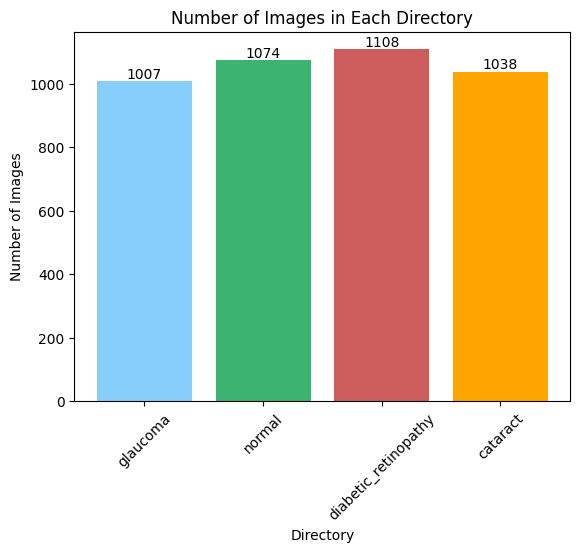

In [ ]:
# Count the number of images in each directory
subfolders = os.listdir(path)

image_counts = []
for directory in subfolders:
    sub_dir = os.path.join(path, directory)
    if os.path.isdir(sub_dir):
        file_count = len(os.listdir(sub_dir))
        image_counts.append(file_count)

#Add value counts on each bar
for i in range(len(subfolders)):
    plt.text(i, image_counts[i], str(image_counts[i]), ha='center', va='bottom')

#Set some colors
colors = ['lightskyblue', 'mediumseagreen', 'indianred', 'orange']

# Plotting the results
plt.bar(subfolders, image_counts, color=colors)
plt.xlabel('Directory')
plt.xticks(rotation = 45)
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Directory')
plt.show()

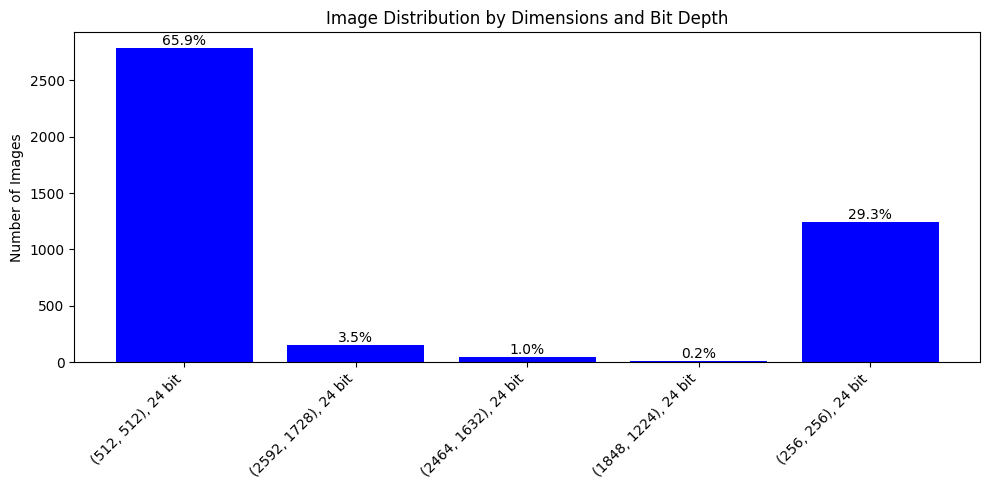

In [ ]:
# Check the photos by size
#The 2nd graph to see total anomalies...To see if all images have the same dim....If they have same dim I don't have to transform it

def dataset_size_analysis(path):
    format_dimensions_counts = defaultdict(int)

    subfolders = os.listdir(path)
    for subfolder in subfolders:
        subfolder_path = os.path.join(path, subfolder)
        if os.path.isdir(subfolder_path):
            files = os.listdir(subfolder_path)

            for file in files:
                try:
                    file_path = os.path.join(subfolder_path, file)
                    with Image.open(file_path) as img:
                        image_dimensions = img.size
                        image_mode = img.mode

                        # Calculate bit depth
                        bit_depth = {
                            "1": 1,
                            "L": 8,
                            "P": 8,
                            "RGB": 24,
                            "RGBA": 32,
                            "CMYK": 32
                        }.get(image_mode, "Unknown")

                        # Update counts
                        format_dimensions_counts[(image_dimensions, bit_depth)] += 1

                except Exception as e:
                    print(f"Exception processing '{file}' in '{subfolder}': {e}")

    # Plotting dimensions and bit depths
    plt.figure(figsize=(10, 5))
    labels = [f"{dims}, {depth} bit" for (dims, depth) in format_dimensions_counts]
    sizes = list(format_dimensions_counts.values())
    total = sum(sizes)
    bars = plt.bar(labels, sizes, color='blue')
    plt.xticks(rotation=45, ha="right")
    plt.ylabel('Number of Images')
    plt.title('Image Distribution by Dimensions and Bit Depth')

    # Adding percentage labels above the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{100 * yval/total:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Set the path to the dataset directory
dataset_size_analysis(path)

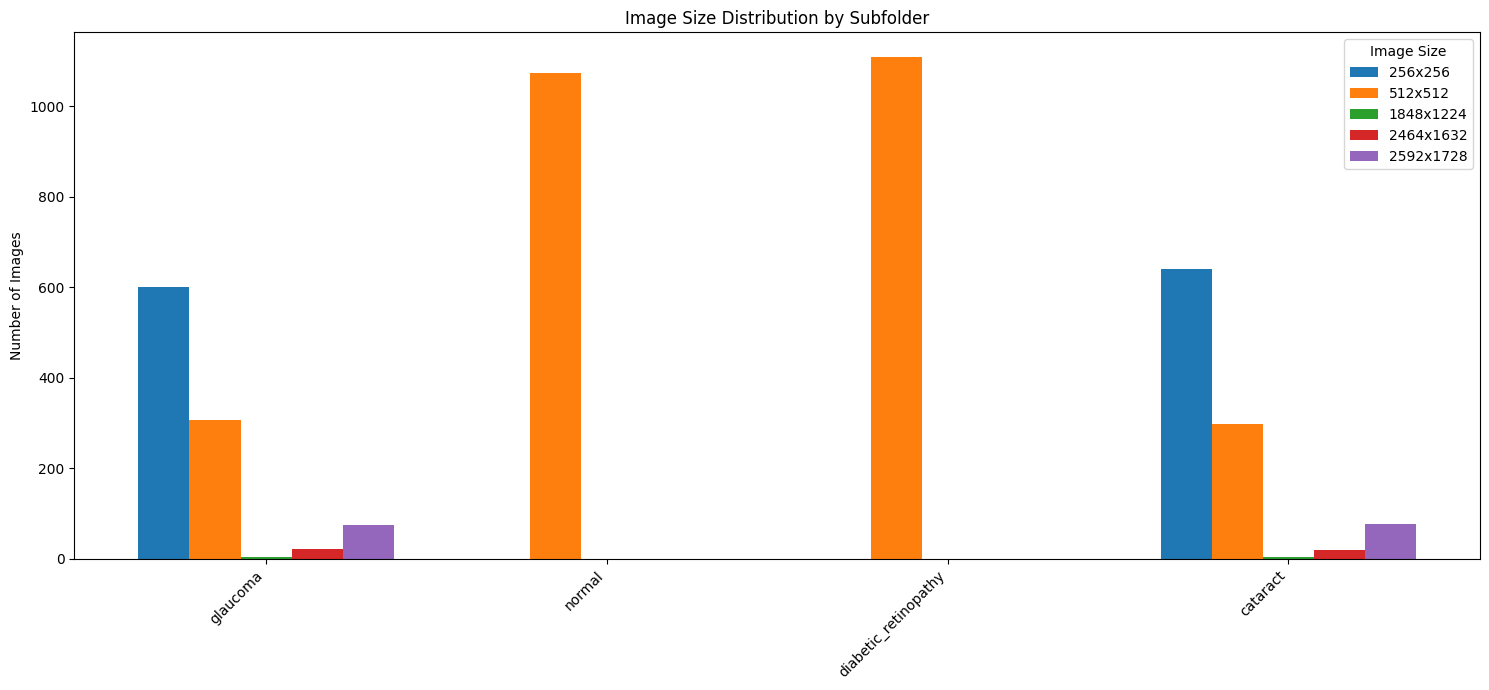

In [ ]:
#3rd graph is to see if data is of same size in each directory/sub folder

def dataset_size_analysis(path):
    # Dictionary to store counts: {subfolder: {image_size: count}}
    folder_size_counts = defaultdict(lambda: defaultdict(int))

    for subfolder in os.listdir(path):
        subfolder_path = os.path.join(path, subfolder)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                try:
                    file_path = os.path.join(subfolder_path, file)
                    with Image.open(file_path) as img:
                        dims = img.size
                        folder_size_counts[subfolder][dims] += 1
                except Exception as e:
                    print(f"Exception processing '{file}' in '{subfolder}': {e}")

    # Create a single plot
    plt.figure(figsize=(15, 7))

    # Determine unique image sizes across all folders for consistent coloring and grouping
    all_sizes = set(size for sizes in folder_size_counts.values() for size in sizes)
    all_sizes = sorted(all_sizes, key=lambda s: (s[0] * s[1]))  # Sort by area

    subfolder_names = list(folder_size_counts.keys())
    bar_width = 0.15  # Width of bars
    indices = range(len(subfolder_names))

    for i, size in enumerate(all_sizes):
        counts = [folder_size_counts[subfolder].get(size, 0) for subfolder in subfolder_names]
        plt.bar([index + i * bar_width for index in indices], counts, bar_width, label=f'{size[0]}x{size[1]}')

    plt.xticks([index + (len(all_sizes) - 1) * bar_width / 2 for index in indices], subfolder_names, rotation=45, ha="right")
    plt.ylabel('Number of Images')
    plt.title('Image Size Distribution by Subfolder')
    plt.legend(title="Image Size")
    plt.tight_layout()
    plt.show()

# Set the path to the dataset directory
dataset_size_analysis(path)

#I wanted to convert the images into 512X512...But u can't convert smaller files 256X256 to 512X512....
#U can go smaller and No all should be of same dimensions...With this graph I  have converted everything to 224X224 later on


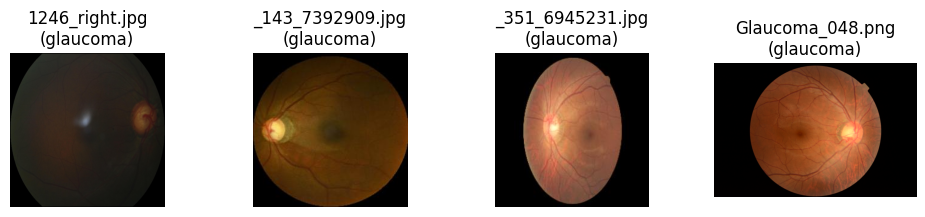

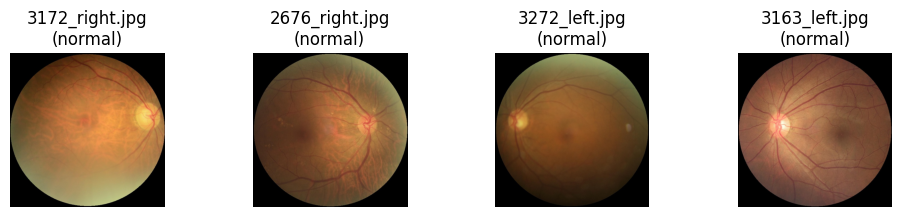

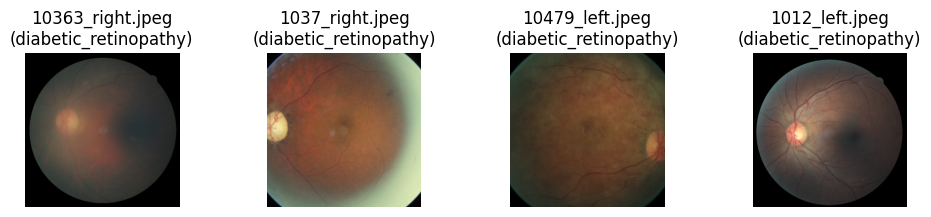

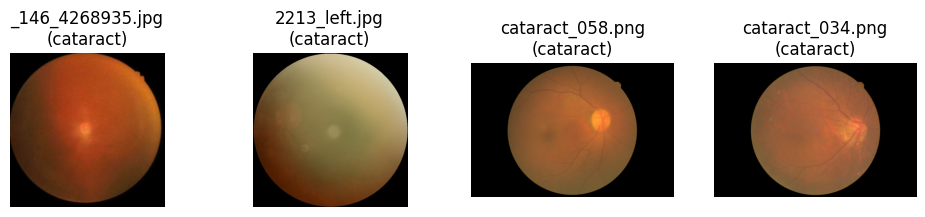

In [ ]:
# Preview photos

def random_photos_from_folders(base_folder):
    # Walk through all directories and files in the base_folder
    for root, dirs, files in os.walk(base_folder):
        # Filter to get only files that are images
        images = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if len(images) >= 4:  # Ensure there are at least 4 images
            selected_images = random.sample(images, 4)  # Randomly select 4 images

            # Display selected images
            fig, axs = plt.subplots(1, 4, figsize=(12, 2))  # Create a 1x4 grid of plots
            for idx, img_name in enumerate(selected_images):
                img_path = os.path.join(root, img_name)
                img = Image.open(img_path)
                axs[idx].imshow(img)
                axs[idx].axis('off')  # Hide axes

                # Extract sub-folder name from the root path
                subfolder_name = os.path.basename(root)
                # Set the title to include image name and sub-folder name
                axs[idx].set_title(f"{img_name}\n({subfolder_name})")

            plt.show()

# Path to the folder containing sub-folders with images

random_photos_from_folders(path)

# Data preparation

In [ ]:
class_dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

# create data path and their labeles
data = []
labels = []
extensions = ["jpg", "JPG", "jpeg", "JPEG", "png", "PNG", "bmp", "BMP", "gif", "GIF"]

for i in class_dirs:
    class_label = i
    image_files = []
    for ext in extensions:
        image_files.extend(glob.glob(os.path.join(path, i, f"*.{ext}")))
    data.extend(image_files)
    labels.extend([class_label] * len(image_files))

if not data:
    print("No files were found. Check your directory paths and file formats.")
else:
    print("Files found and listed.")


df = pd.DataFrame({
'filename': data,
'class': labels
})


df = df.sample(frac=1)

Files found and listed.


In [ ]:
display(df)

,filename,class
2722,/content/drive/MyDrive/Colab Notebooks/archive...,diabetic_retinopathy
3232,/content/drive/MyDrive/Colab Notebooks/archive...,cataract
667,/content/drive/MyDrive/Colab Notebooks/archive...,glaucoma
535,/content/drive/MyDrive/Colab Notebooks/archive...,glaucoma
40,/content/drive/MyDrive/Colab Notebooks/archive...,glaucoma
...,...,...
2314,/content/drive/MyDrive/Colab Notebooks/archive...,diabetic_retinopathy
428,/content/drive/MyDrive/Colab Notebooks/archive...,glaucoma
225,/content/drive/MyDrive/Colab Notebooks/archive...,glaucoma
3230,/content/drive/MyDrive/Colab Notebooks/archive...,cataract


In [ ]:
#Label encoding assigns a unique integer to each category, preserving the ordinal relationships between categories but not the magnitude of those relationships.
#On the other hand, one-hot encoding creates a separate column for each category, capturing the magnitude of relationships but not the ordinal relationships.
# Convert labels to one-hot encodings
label_encoder = LabelEncoder()
label = label_encoder.fit_transform(df['class'])
df['class'] = label

class_names = label_encoder.classes_
class_numbers = label_encoder.transform(label_encoder.classes_)

# Print class names with the assigned numbers
class_dict = dict(zip(class_names, class_numbers))
print(class_dict)

{'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}


In [ ]:
display(df)

,filename,class
2722,/content/drive/MyDrive/Colab Notebooks/archive...,1
3232,/content/drive/MyDrive/Colab Notebooks/archive...,0
667,/content/drive/MyDrive/Colab Notebooks/archive...,2
535,/content/drive/MyDrive/Colab Notebooks/archive...,2
40,/content/drive/MyDrive/Colab Notebooks/archive...,2
...,...,...
2314,/content/drive/MyDrive/Colab Notebooks/archive...,1
428,/content/drive/MyDrive/Colab Notebooks/archive...,2
225,/content/drive/MyDrive/Colab Notebooks/archive...,2
3230,/content/drive/MyDrive/Colab Notebooks/archive...,0


# Divide data into (train, validation, test)

In dividing the data into three parts, it is important to maintain the distribution ratio of the data in the original dataset. Because I want the three parts of Train + Validation + Test to have the same ratio of data and to have the same amount of data for training for each class.

In [ ]:
# Check the balance of the classes
print(df['class'].value_counts(normalize=True))
print('------'*10)

# Split the data into train+validation and test sets
train_plus_val, test = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)

# random_state simply sets a seed to the random generator, so that your train-test splits are always deterministic.
# If you don't set a seed, it is different each time.
# Split the data into train+validation and test sets
train, val = train_test_split(train_plus_val, test_size=0.25, stratify=train_plus_val['class'], random_state=42)  # 0.25 x 0.8 = 0.2

# train: 60%
# val: 20%
# test: 20%
#The train-test split procedure is used to estimate how well a machine learning algorithm will perform when it's used to make predictions on data it hasn't been trained on
#Test Data: A separate subset of the dataset not seen by the model during training. This data is used to evaluate how well the model performs on unseen examples.
#How Randomization is Applied
# 1. Random Sampling: When splitting a dataset into training and testing sets, random sampling ensures that data points are selected randomly for each subset.
#This can be done using functions in programming libraries (like train_test_split in scikit-learn for Python) that automatically shuffle the data before splitting.
#2.Proportional Splits: Typically, a percentage of the data (commonly 70-80% for training and 20-30% for testing) is randomly assigned to each subset.
#This helps maintain the distribution of classes or values in both sets, especially in classification tasks.


# Confirm the distribution across splits
print("Training set:")
print(train['class'].value_counts(normalize=True))
print('------'*10)


print("Validation set:")
print(val['class'].value_counts(normalize=True))
print('------'*10)


print("Test set:")
print(test['class'].value_counts(normalize=True))
#The purpose of this code is to give a quick overview of the class distribution in the training set, which is useful for understanding if the dataset
# is balanced(Whatever number comes, it shouldn't vary a lot) or if there are any potential issues with class imbalance that could affect model training and evaluation.

class
1    0.262124
3    0.254081
0    0.245564
2    0.238230
Name: proportion, dtype: float64
------------------------------------------------------------
Training set:
class
1    0.261933
3    0.254043
0    0.245365
2    0.238659
Name: proportion, dtype: float64
------------------------------------------------------------
Validation set:
class
1    0.262411
3    0.254137
0    0.245863
2    0.237589
Name: proportion, dtype: float64
------------------------------------------------------------
Test set:
class
1    0.262411
3    0.254137
0    0.245863
2    0.237589
Name: proportion, dtype: float64


In [ ]:
train_links, train_labels = train['filename'].values , train['class'].values
val_links , val_labels = val['filename'].values , val['class'].values
test_links, test_labels = test['filename'].values , test['class'].values

# Load and Preprocess Images

In [ ]:
# Create a Function to Load and Preprocess Images
#here we are converting images to tensor format


def load_and_preprocess_image(path, label, data_augmentation=True):
    # Read the image file
    image = tf.io.read_file(path)

    # Extract file extension
    file_extension = tf.strings.split(path, '.')[-1]

    # Decode based on file extension using tf.cond
    def decode_jpeg():
        return tf.image.decode_jpeg(image, channels=3)

    def decode_png():
        return tf.image.decode_png(image, channels=3)

    def decode_bmp():
        return tf.image.decode_bmp(image, channels=3)

    def decode_gif():
        # Decode GIF and take the first frame
        return tf.squeeze(tf.image.decode_gif(image), axis=0)

    # Handle each format
    image = tf.cond(tf.math.equal(file_extension, 'jpg'), decode_jpeg,
            lambda: tf.cond(tf.math.equal(file_extension, 'jpeg'), decode_jpeg,
            lambda: tf.cond(tf.math.equal(file_extension, 'png'), decode_png,
            lambda: tf.cond(tf.math.equal(file_extension, 'bmp'), decode_bmp,
            lambda: tf.cond(tf.math.equal(file_extension, 'gif'), decode_gif,
            decode_jpeg)))))

    # Resize and normalize
    image = tf.image.resize(image, [256, 256])
    image = image / 255.0  # Normalize to [0, 1] range

    # Apply data augmentation if in training mode
    if data_augmentation == True:
        # Randomly flip the image horizontally
        image = tf.image.random_flip_left_right(image)

        # Randomly flip the image vertically
        image = tf.image.random_flip_up_down(image)

        # Randomly rotate the image
        image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

        # Randomly adjust brightness
        image = tf.image.random_brightness(image, max_delta=0.1)

        # Randomly zoom in
        image = tf.image.resize_with_crop_or_pad(image, 266, 266)  # Zoom in slightly
        image = tf.image.random_crop(image, size=[256, 256, 3])

        # Randomly adjust contrast
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image, label


In [ ]:

# create TensorFlow datasets for each split
# When loading datasets, pass the data_augmentation flag True or False to apply or skip augmentations
#Data augmentation is a technique used to artificially expand the size of a training dataset by applying various transformations to the existing data.
# It’s especially useful in fields like image classification, where having a larger and more diverse dataset can improve model performance and generalization.

train_dataset = tf.data.Dataset.from_tensor_slices( (train_links , train_labels) )
train_dataset = train_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=True), num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices( (val_links , val_labels) )
val_dataset = val_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=False), num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices( (test_links , test_labels) )
test_dataset = test_dataset.map(lambda x, y: load_and_preprocess_image(x, y, data_augmentation=False), num_parallel_calls=tf.data.AUTOTUNE)



In [ ]:
# Iterate over the dataset and print the first few elements
for data_element, label_element in train_dataset.take(1):
    print(f"Data: {data_element.numpy()}, Label: {label_element.numpy()}")


Data: [[[-0.0300484  -0.04587002 -0.04965475]
  [-0.0300484  -0.04587002 -0.04965475]
  [-0.0300484  -0.04587002 -0.04965475]
  ...
  [ 0.01824144  0.00241982 -0.00136491]
  [ 0.01824144  0.00241982 -0.00136491]
  [ 0.01824144  0.00241982 -0.00136491]]

 [[-0.0300484  -0.04587002 -0.04965475]
  [-0.0300484  -0.04587002 -0.04965475]
  [-0.0300484  -0.04587002 -0.04965475]
  ...
  [ 0.01824144  0.00241982 -0.00136491]
  [ 0.01824144  0.00241982 -0.00136491]
  [ 0.01824144  0.00241982 -0.00136491]]

 [[-0.0300484  -0.04587002 -0.04965475]
  [-0.0300484  -0.04587002 -0.04965475]
  [-0.0300484  -0.04587002 -0.04965475]
  ...
  [ 0.01824144  0.00241982 -0.00136491]
  [ 0.01824144  0.00241982 -0.00136491]
  [ 0.01824144  0.00241982 -0.00136491]]

 ...

 [[ 0.01824144  0.00241982 -0.00136491]
  [ 0.01824144  0.00241982 -0.00136491]
  [ 0.01824144  0.00241982 -0.00136491]
  ...
  [ 0.01824144  0.00241982 -0.00136491]
  [ 0.01824144  0.00241982 -0.00136491]
  [ 0.01824144  0.00241982 -0.00136491

In [ ]:
# Iterate over the dataset and print the first few elements
for data_element, label_element in train_dataset.take(1):
    print(f"Data: {data_element.numpy().shape}, Label: {label_element.numpy()}")


Data: (256, 256, 3), Label: 2


In [ ]:
#Datasets for model training and evaluation

batch_size = 16

train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size= tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Create Model

In [ ]:
#CNN
#Convolutional Neural Networks (CNNs), ReLU (Rectified Linear Unit) and Softmax are two important activation functions used at different stages of the network.
#Workflow in a CNN
#1.Convolutional Layers: Convolutional layers apply filters to the input images to extract features.
#2.Activation (ReLU): After each convolutional layer, ReLU is applied to introduce non-linearity.
#3.Pooling Layers: Pooling layers downsample the feature maps to reduce dimensionality while retaining important features.
#4.Fully Connected Layer(s): After several convolutional and pooling layers, the output is flattened and passed through fully connected layers.
#5.Output Layer (Softmax): The final fully connected layer uses the Softmax activation to produce class probabilities for classification tasks.
#The ReLU function is defined as 𝑓(𝑥)=max(0,x).This means that if the input is positive, it remains unchanged; if it's negative, it outputs zero.
# Usage: ReLU is typically used in the hidden layers of CNNs. It introduces non-linearity to the model, allowing the network to learn complex patterns.
# Softmax: The Softmax function converts a vector of raw scores (logits) into probabilities
#Usage: Softmax is typically used in the output layer of a CNN for multi-class classification tasks.It outputs a probability distribution over multiple classes,
#where the probabilities sum to 1.



model = models.Sequential([
    # First Block
    layers.Conv2D(128, (3, 3), activation='relu', input_shape=(256, 256, 3), padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),


    # Second Block
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Second Block
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Second Block
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.Conv2D(256, (3, 3), activation='relu',padding='valid'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),



    # Global Average Pooling instead of Flatten
    layers.GlobalAveragePooling2D(),

    # Fully Connected Layers
    layers.Dense(512,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # Output layer
])


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 124, 124, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 62, 62, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 58, 58, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 29, 29, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 29, 29, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 27, 27, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │              

 Total params: 3,533,956 (13.48 MB)

 Trainable params: 3,532,164 (13.47 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
# Define the EarlyStopping callback to monitor the validation accuracy
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitoring validation accuracy
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='max',
    restore_best_weights=True
)


# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath=r'/content/drive/MyDrive/Colab Notebooks/model_29.keras',  # Path to save the model file
    monitor='val_loss',  # Change to val_loss to monitor the validation loss
    verbose=1,
    save_best_only=True,  # Save only the best model
    mode='min'  # Save the model when the monitored metric has minimized

)


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Fit the model
history = model.fit(
    x = train_dataset,
    validation_data = val_dataset,
    epochs = 30,
    callbacks=[early_stopping , model_checkpoint]  # Add the EarlyStopping callback
)


Epoch 1/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.3142 - loss: 1.5045
Epoch 1: val_loss improved from inf to 1.88962, saving model to /content/drive/MyDrive/Colab Notebooks/model_29.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 182s 856ms/step - accuracy: 0.3143 - loss: 1.5042 - val_accuracy: 0.2506 - val_loss: 1.8896
Epoch 2/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.3728 - loss: 1.3238
Epoch 2: val_loss improved from 1.88962 to 1.18301, saving model to /content/drive/MyDrive/Colab Notebooks/model_29.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 101s 487ms/step - accuracy: 0.3729 - loss: 1.3236 - val_accuracy: 0.4657 - val_loss: 1.1830
Epoch 3/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.4832 - loss: 1.1751
Epoch 3: val_loss did not improve from 1.18301
159/159 ━━━━━━━━━━━━━━━━━━━━ 79s 497ms/step - accuracy: 0.4832 - loss: 1.1751 - val_accuracy: 0.3286 - val_loss: 1.2958
Epoch 4/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.4674 - loss: 1.1481

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/model_29.keras')
#/content/drive/MyDrive/Colab Notebooks/model_29.keras

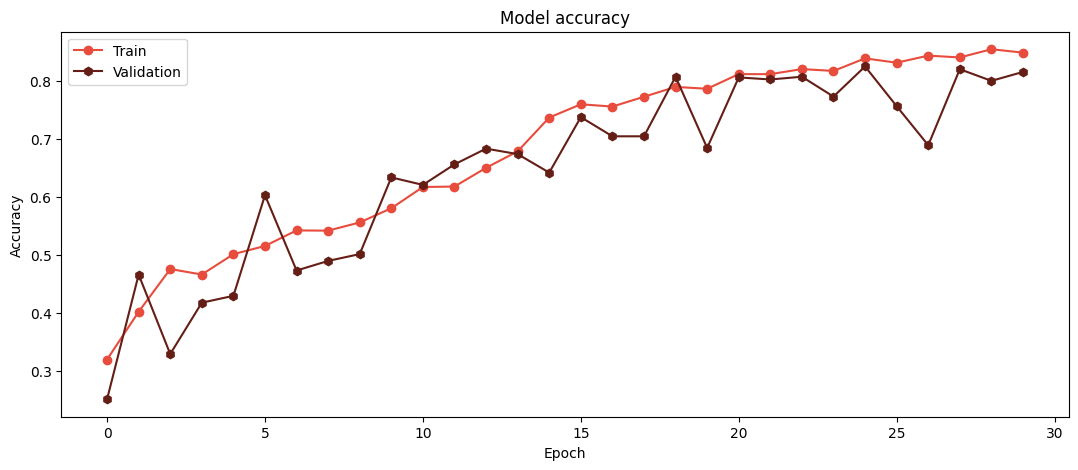

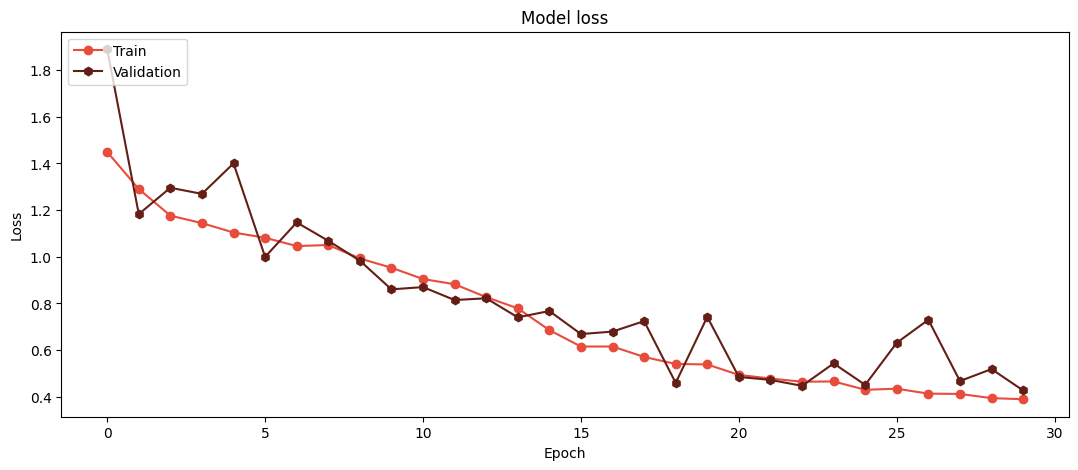

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(13,5))
plt.plot(history.history['accuracy'],color="#E74C3C", marker='o')
plt.plot(history.history['val_accuracy'], color='#641E16', marker='h')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(13,5))
plt.plot(history.history['loss'],color="#E74C3C", marker='o')
plt.plot(history.history['val_loss'], color='#641E16', marker='h')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend( ['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Load the saved model
# If the best model is captured by the early stopping mechanism then best_model = model
# best_model = model

best_model = load_model(r'/content/drive/MyDrive/Colab Notebooks/model_29.keras')



# Evaluate the model
train_loss, train_accuracy = best_model.evaluate(train_dataset)
val_loss, val_accuracy = best_model.evaluate(val_dataset)
test_loss, test_accuracy = best_model.evaluate(test_dataset)

print(f"train loss: {train_loss}")
print(f"train accuracy: {train_accuracy}")
print('----'*6)
print(f"val loss: {val_loss}")
print(f"val accuracy: {val_accuracy}")
print('----'*6)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 210ms/step - accuracy: 0.7697 - loss: 0.5677
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.8182 - loss: 0.4765
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.8399 - loss: 0.4593
train loss: 0.5541045069694519
train accuracy: 0.7783037424087524
------------------------
val loss: 0.4511566460132599
val accuracy: 0.8250591158866882
------------------------
Test loss: 0.45984312891960144
Test accuracy: 0.8321512937545776


In [ ]:
#we r loading model now Once it's saved  To see if it works or not

# Assuming best_model is your trained Keras model

# Get the predicted labels from the model
y_pred = np.argmax( best_model.predict(test_dataset) , axis=1 ) # Convert probabilities to class indices
y_true = test_labels

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# A confusion matrix is a useful tool for evaluating the performance of a classification model, particularly in binary and multi-class classification tasks.
# It provides a summary of the correct and incorrect predictions made by the model, allowing for a deeper understanding of its performance.

print("Confusion Matrix:")
print(conf_mat)

# Get the class labels from the LabelEncoder
class_labels = label_encoder.classes_

# Compute classification report
report = classification_report(y_true, y_pred, target_names=class_labels)

print("\nClassification Report:")
print(report)

#Metrics Derived from the Confusion Matrix:
#1.Accuracy: The proportion of total correct predictions (both true positives and true negatives) out of all predictions.
#2.Precision: The proportion of true positive predictions out of all positive predictions.
#3.Recall (Sensitivity): The proportion of true positive predictions out of all actual positive instances.
#4.F1 Score: The harmonic mean of precision and recall, useful for imbalanced classes.
#5.Specificity: The proportion of true negative predictions out of all actual negative instances.



53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step
Confusion Matrix:
[[177   0  17  14]
 [  2 207   5   8]
 [ 13  10 139  39]
 [  4  12  18 181]]

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.90      0.85      0.88       208
diabetic_retinopathy       0.90      0.93      0.92       222
            glaucoma       0.78      0.69      0.73       201
              normal       0.75      0.84      0.79       215

            accuracy                           0.83       846
           macro avg       0.83      0.83      0.83       846
        weighted avg       0.83      0.83      0.83       846



Total Number Of Test data:  846


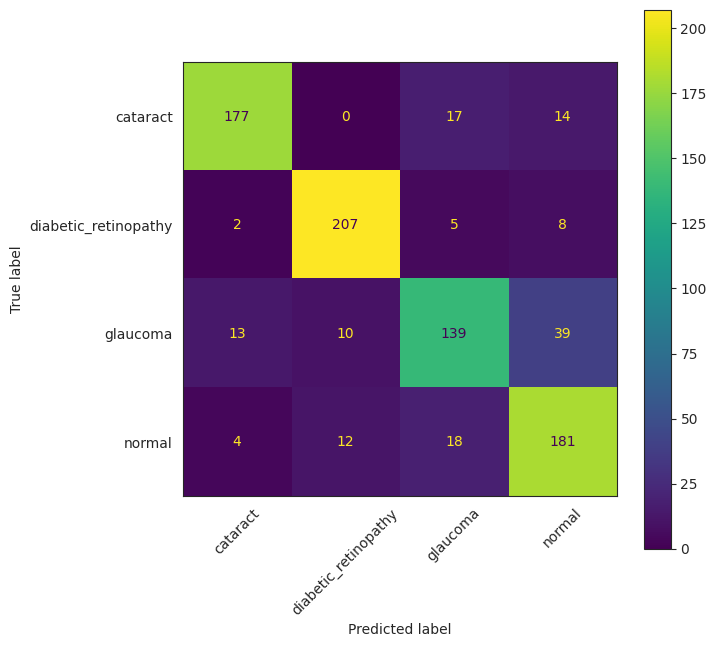

In [ ]:
#Confusion matrix
print('Total Number Of Test data: ', len(test_labels))

sn.set_style("white")
def plot_confusion_matrix(conf_mat, classes):
    """
    This function prints and plots the confusion matrix.
    """
    fig, ax = plt.subplots(figsize=(7,7)) # change the plot size
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
    disp = disp.plot(include_values=True,cmap='viridis', ax=ax, xticks_rotation=45)
    plt.show()

# Get your confusion matrix
conf_mat = conf_mat

# Using label_encoder.classes_ guarantees that class_names matches
# the order that was used during the one-hot encoding process
class_names = label_encoder.classes_

# Now plot using the function
plot_confusion_matrix(conf_mat, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


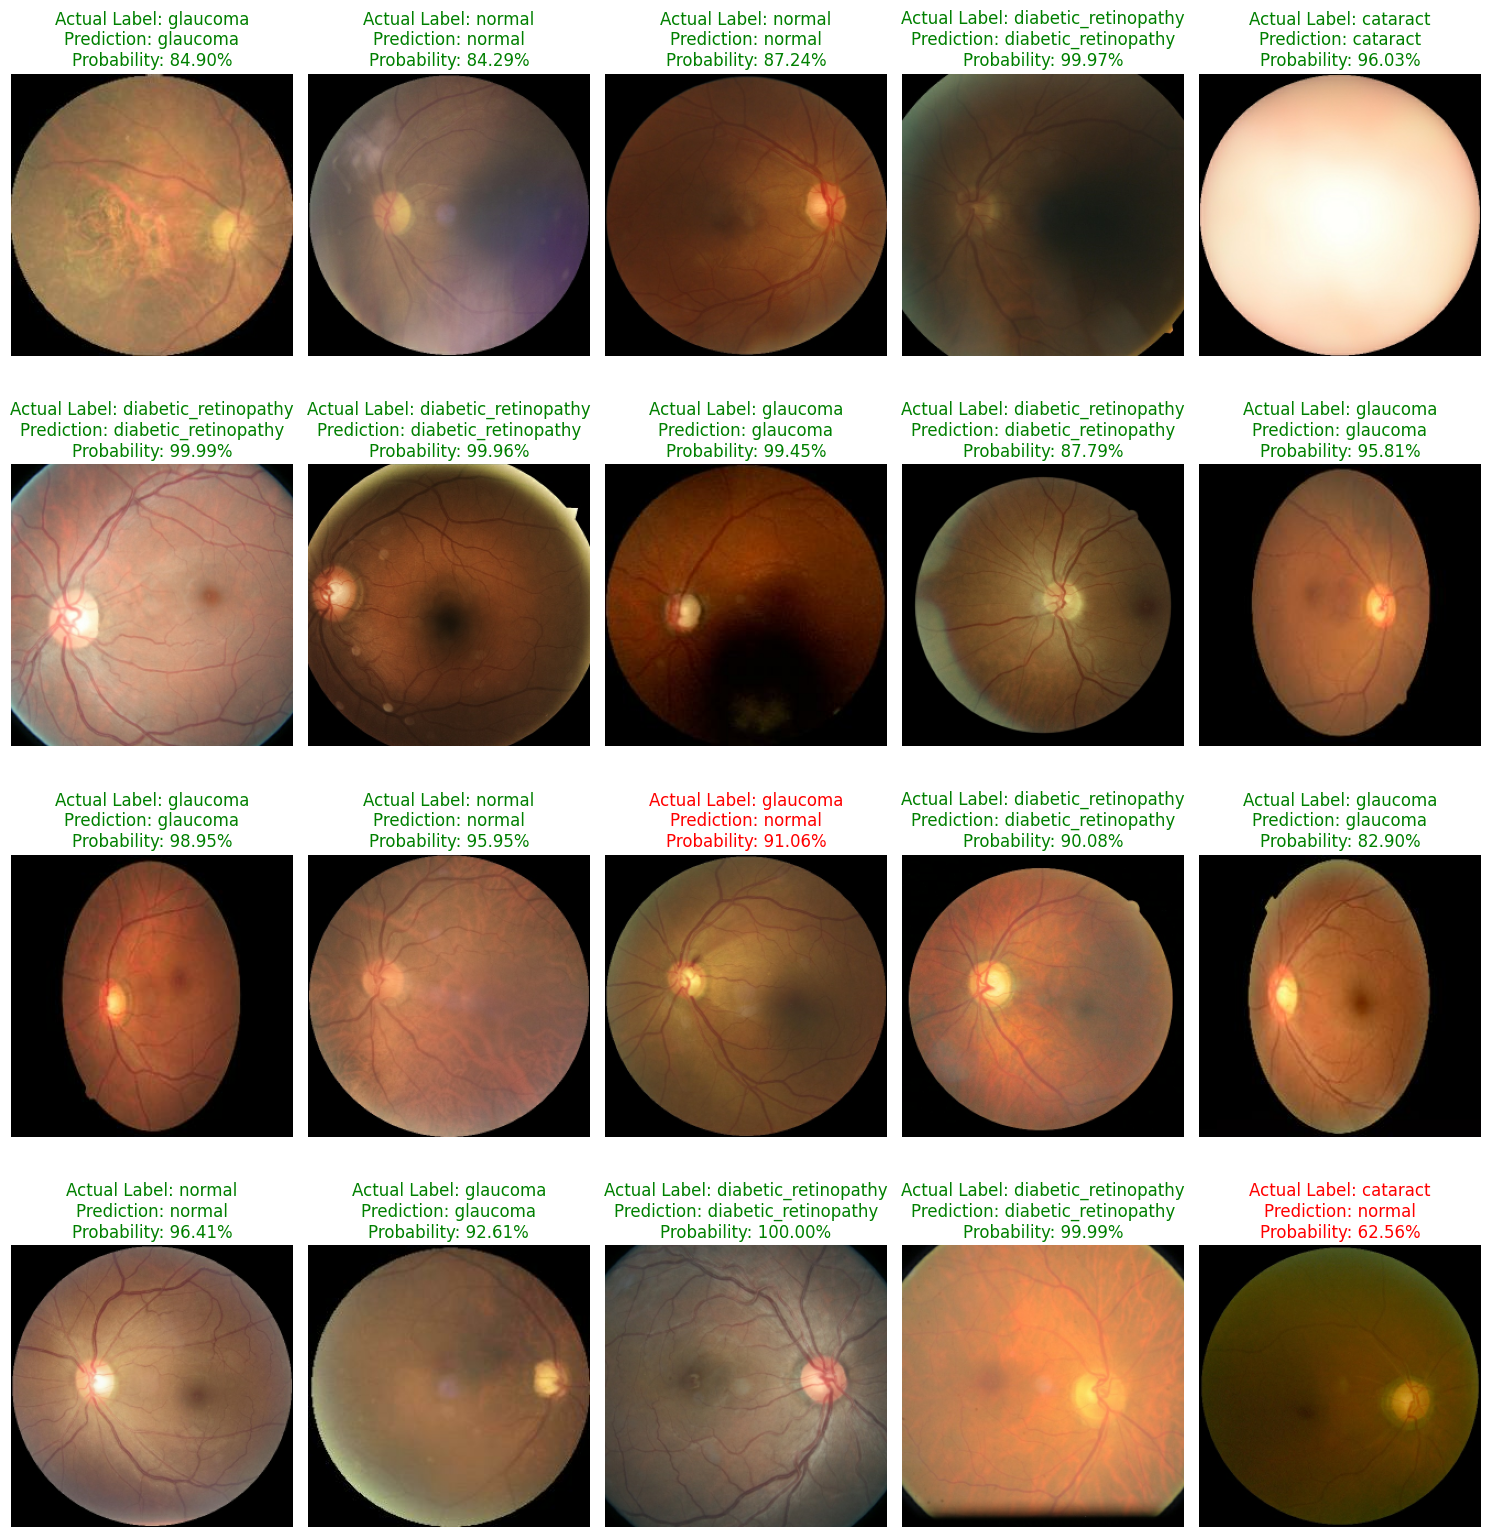

In [ ]:
# probability explanation in below function:
# For example, if the model predicts an image as class B with a probability of 0.7 (or 70%),
# the plot will show "Probability: 70%".
# This means the model is 70% confident that the image belongs to class B.


def plot_test_predictions(model, test_dataset, class_labels, num_images=20):
    """
    Plots the predictions of a model on the test dataset.

    Parameters:
    - model: Trained Keras model to be used for prediction.
    - test_dataset: TensorFlow dataset containing the test images and labels.
    - class_labels: List of class labels.
    - num_images: Number of test images to plot (default is 20).
    """

    # Initialize lists to accumulate images and labels
    images = []
    true_labels = []
    pred_labels = []
    pred_probs = []

    for batch_images, batch_labels in test_dataset:
        # Predict on the batch
        batch_pred_probs = model.predict(batch_images)
        batch_pred_labels = np.argmax(batch_pred_probs, axis=1)

        # Accumulate images and labels
        images.extend(batch_images)
        true_labels.extend(batch_labels)
        pred_labels.extend(batch_pred_labels)
        pred_probs.extend(np.max(batch_pred_probs, axis=1) * 100)

        if len(images) >= num_images:
            break

    # Plot the images with predictions
    plt.figure(figsize=(15, 20))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        actual_label = class_labels[true_labels[i]]
        predicted_label = class_labels[pred_labels[i]]
        probability = pred_probs[i]  # Probability of the predicted class

        color = 'green' if actual_label == predicted_label else 'red'
        plt.title(f"Actual Label: {actual_label}\nPrediction: {predicted_label}\nProbability: {probability:.2f}%",
                  color=color, fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Use the function
plot_test_predictions(best_model, test_dataset, class_labels=class_names, num_images=50)
